<a href="https://colab.research.google.com/github/aniketsharma00411/sign-language-to-text-translator/blob/main/efficient_net_b0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
from google.colab import files
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input
from keras.applications.efficientnet import EfficientNetB0
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [ ]:
if not os.path.exists(os.path.expanduser('~')+'/.kaggle'):
    ! mkdir ~/.kaggle
os.chdir(os.path.expanduser('~')+'/.kaggle')
if not os.path.exists(os.path.expanduser('~')+'/.kaggle/kaggle.json'):
    kaggle_api_file = files.upload()
    ! kaggle datasets download -d grassknoted/asl-alphabet
    ! unzip -q asl-alphabet.zip
    ! rm -rf asl_alphabet_train/asl_alphabet_train/del

Saving kaggle.json to kaggle.json
 99% 1.01G/1.03G [00:07<00:00, 89.8MB/s]
100% 1.03G/1.03G [00:08<00:00, 137MB/s] 


In [ ]:
! ls

asl_alphabet_test  asl_alphabet_train  asl-alphabet.zip  kaggle.json


# Data preprocessing

In [ ]:
train_data = 'asl_alphabet_train/asl_alphabet_train'

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               validation_split=0.2)

In [ ]:
train_gen = image_gen.flow_from_directory(train_data,
                                          target_size=(224,224),
                                          class_mode='categorical',
                                          color_mode='rgb',
                                          shuffle=True,
                                          batch_size=32,
                                          seed=0,
                                          subset='training')

Found 67200 images belonging to 28 classes.


In [ ]:
val_gen = image_gen.flow_from_directory(train_data,
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=True,
                                        batch_size=32,
                                        seed=0,
                                        subset='validation')

Found 16800 images belonging to 28 classes.


In [ ]:
train_gen.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'nothing': 26,
 'space': 27}

# Creating model

In [ ]:
base_model = EfficientNetB0(include_top=False,
                            weights='imagenet',
                            input_shape=(224,224,3),
                            pooling='avg')

end_model = models.Sequential()
end_model.add(layers.Flatten(input_shape=base_model.output_shape[1:]))
end_model.add(layers.Dense(64))
end_model.add(layers.LeakyReLU())
end_model.add(layers.Dense(64))
end_model.add(layers.LeakyReLU())
end_model.add(layers.Dense(28, activation='softmax'))

model = models.Model(inputs=base_model.input, outputs=end_model(base_model.output))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        mode='min',
                                        restore_best_weights=True)

# Training the model

In [ ]:
history = model.fit(train_gen,
                    epochs=20,
                    validation_data=val_gen,
                    callbacks=[early_stopping_callback])

Epoch 1/20
2100/2100 [==============================] - 238s 86ms/step - loss: 0.5033 - accuracy: 0.8717 - val_loss: 0.3485 - val_accuracy: 0.8948
Epoch 2/20
2100/2100 [==============================] - 175s 83ms/step - loss: 0.0348 - accuracy: 0.9892 - val_loss: 0.3423 - val_accuracy: 0.9052
Epoch 3/20
2100/2100 [==============================] - 175s 83ms/step - loss: 0.0245 - accuracy: 0.9924 - val_loss: 0.3714 - val_accuracy: 0.9090
Epoch 4/20
2100/2100 [==============================] - 175s 83ms/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.3410 - val_accuracy: 0.9080
Epoch 5/20
2100/2100 [==============================] - 175s 83ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.4645 - val_accuracy: 0.8908
Epoch 6/20
2100/2100 [==============================] - 174s 83ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.4158 - val_accuracy: 0.9038
Epoch 7/20
2100/2100 [==============================] - 172s 82ms/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 0

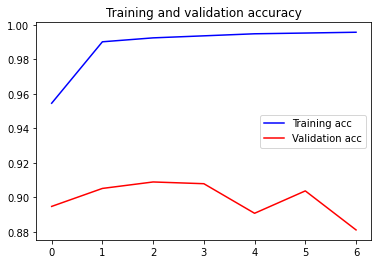

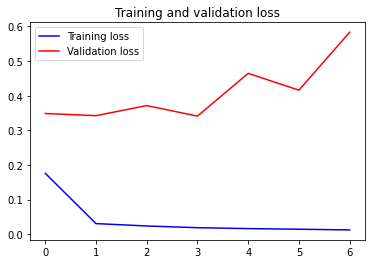

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Saving Model

In [ ]:
model.save('../asl_efficient_net_b0.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
